# Polystyrene Creep

Fit polystyrene creep at selectable temperature.

**Data:** examples/data/creep/polymers/creep_ps130_data.csv (swap for other temps)


In [1]:
# Google Colab compatibility - uncomment if running in Colab
# !pip install -q rheojax
# from google.colab import drive
# drive.mount('/content/drive')


## Setup and Imports

In [2]:
# Configure matplotlib for inline plotting in VS Code/Jupyter
%matplotlib inline

import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from rheojax.core.data import RheoData
from rheojax.core.jax_config import safe_import_jax, verify_float64
from rheojax.models import FractionalMaxwellModel, GeneralizedMaxwell
from rheojax.pipeline.base import Pipeline

jax, jnp = safe_import_jax()
verify_float64()
np.set_printoptions(precision=4, suppress=True)
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 11
warnings.filterwarnings('ignore', category=RuntimeWarning)

def r2_complex(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    ss_res = np.sum(np.abs(y_true - y_pred) ** 2)
    ss_tot = np.sum(np.abs(y_true - np.mean(y_true)) ** 2)
    return float(1 - ss_res / ss_tot)

def mpe(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    return float(np.mean(np.abs(y_true - y_pred) / np.maximum(np.abs(y_true), 1e-12)) * 100)

def load_tab_file(path):
    df = pd.read_csv(path, sep='	')
    df.columns = df.columns.str.strip()
    df = df.dropna()
    df.iloc[:,0] = pd.to_numeric(df.iloc[:,0], errors='coerce')
    df.iloc[:,1] = pd.to_numeric(df.iloc[:,1], errors='coerce')
    df = df.dropna()
    return df
import os
import sys

import arviz as az

# Shared plotting utilities
sys.path.insert(0, os.path.join(os.path.dirname(os.path.abspath("")), ".."))
from utils.plotting_utils import display_arviz_diagnostics


## Load creep data (select temperature file)

In [3]:
DATA_DIR = Path.cwd().parent / 'data' / 'creep' / 'polymers'
file = DATA_DIR / 'creep_ps130_data.csv'  # swap for other temps

if not file.exists():
    raise FileNotFoundError(f"Creep data not found at {file}. Check that data symlink exists.")

df = load_tab_file(file)
t = df.iloc[:,0].to_numpy()
J = df.iloc[:,1].to_numpy()

## Fit creep models

In [4]:
gm = GeneralizedMaxwell(n_modes=2, modulus_type='tensile')  # Reduced modes for faster Bayesian
gm.fit(t, J, test_mode='creep', use_log_residuals=True)
gm_pred = gm.predict(t)
gm_r2 = gm.score(t, J)

# FractionalMaxwellModel may not converge for all creep datasets
fm_pred = np.full_like(J, np.nan)
fm_r2 = np.nan
try:
    fm = FractionalMaxwellModel()
    fm.fit(t, J, test_mode='creep', use_log_residuals=True)
    fm_pred = fm.predict(t, test_mode='creep')
    fm_r2 = r2_complex(J, fm_pred)
except Exception as exc:
    print(f"Fractional Maxwell fit failed (expected for some creep data): {exc}")

print({'gm_r2': gm_r2, 'fm_r2': fm_r2})

INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=5 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=1.793680s


INFO:nlsq.least_squares:Convergence reason=`xtol` termination condition is satisfied. | iterations=25 | final_cost=5.4785e-07 | elapsed=1.794s | final_gradient_norm=1.9702e-06


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=5 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.838200s


INFO:nlsq.least_squares:Convergence reason=`xtol` termination condition is satisfied. | iterations=25 | final_cost=5.4785e-07 | elapsed=0.838s | final_gradient_norm=1.9702e-06


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=3 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.744233s


INFO:nlsq.least_squares:Convergence reason=`gtol` termination condition is satisfied. | iterations=22 | final_cost=4.9276e-07 | elapsed=0.744s | final_gradient_norm=8.8265e-07


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=4 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


[WARNING] Inner optimization loop hit iteration limit inner_iterations=100 | actual_reduction=-1


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=10.512790s


INFO:nlsq.least_squares:Convergence reason=Inner optimization loop exceeded maximum iterations. | iterations=1 | final_cost=1.9179e+32 | elapsed=10.513s | final_gradient_norm=nan


ERROR:rheojax.utils.optimization:Failed to compute covariance from Jacobian
Traceback (most recent call last):
  File "/Users/b80985/Projects/rheojax/rheojax/utils/optimization.py", line 87, in compute_covariance_from_jacobian
    U, s, VT = np.linalg.svd(jac, full_matrices=False)
               ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/b80985/Projects/rheojax/.venv/lib/python3.13/site-packages/numpy/linalg/_linalg.py", line 1862, in svd
    u, s, vh = gufunc(a, signature=signature)
               ~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/b80985/Projects/rheojax/.venv/lib/python3.13/site-packages/numpy/linalg/_linalg.py", line 172, in _raise_linalgerror_svd_nonconvergence
    raise LinAlgError("SVD did not converge")
numpy.linalg.LinAlgError: SVD did not converge


{'gm_r2': 0.9792668199066927, 'fm_r2': -3.7792105746946176e+28}


## Plot creep fits

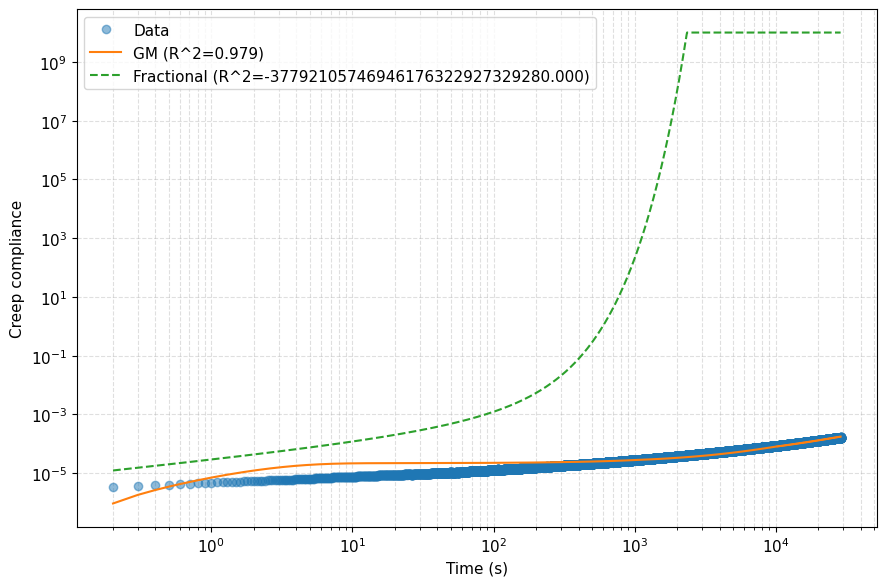

In [5]:
fig, ax = plt.subplots(figsize=(9,6))
ax.loglog(t, J, 'o', label='Data', alpha=0.5)
ax.loglog(t, gm_pred, '-', label=f'GM (R^2={gm_r2:.3f})')
ax.loglog(t, fm_pred, '--', label=f'Fractional (R^2={fm_r2:.3f})')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Creep compliance')
ax.grid(True, which='both', ls='--', alpha=0.4)
ax.legend()
plt.tight_layout()
display(fig)
plt.close(fig)

## Bayesian workflow (NLSQ → best model → NUTS diagnostics)

In [6]:
# Helper functions for workflow
if 'r2_complex' not in globals():
    def r2_complex(y_true, y_pred):
        """Compute R² for complex-valued data."""
        y_true = np.asarray(y_true)
        y_pred = np.asarray(y_pred)
        ss_res = np.sum(np.abs(y_true - y_pred) ** 2)
        ss_tot = np.sum(np.abs(y_true - np.mean(y_true)) ** 2)
        return 1 - ss_res / ss_tot

if '_coerce_pred' not in globals():
    def _coerce_pred(pred):
        """Convert 2-column real array to complex if needed."""
        arr = np.asarray(pred)
        if arr.ndim == 2 and arr.shape[1] == 2 and not np.iscomplexobj(arr):
            arr = arr[:, 0] + 1j * arr[:, 1]
        return arr

NUTS_CONFIG = dict(num_chains=1, num_warmup=200, num_samples=500)  # Fast demo mode


In [7]:
def _detect_datasets():
    """Auto-detect datasets from global variables."""
    datasets = []
    if 'G_star' in globals() and 'omega' in globals():
        datasets.append({
            'X': omega, 'y': G_star, 'test_mode': 'oscillation',
            'x_label': 'Angular frequency (rad/s)', 'y_label': 'Complex modulus',
        })
    elif 'Gp' in globals() and 'Gpp' in globals() and 'omega' in globals():
        datasets.append({
            'X': omega, 'y': Gp + 1j * Gpp, 'test_mode': 'oscillation',
            'x_label': 'Angular frequency (rad/s)', 'y_label': 'Complex modulus',
        })
    if 'master' in globals() and hasattr(master, 'x') and hasattr(master, 'y'):
        test_mode = master.metadata.get('test_mode', 'oscillation') if hasattr(master, 'metadata') else 'oscillation'
        datasets.append({
            'X': master.x, 'y': master.y, 'test_mode': test_mode,
            'x_label': 'Shifted frequency', 'y_label': 'Mastercurve modulus',
        })
    if 't' in globals() and 'G' in globals():
        datasets.append({'X': t, 'y': G, 'test_mode': 'relaxation', 'x_label': 'Time (s)', 'y_label': 'Relaxation modulus'})
    if 't' in globals() and 'E_t' in globals():
        datasets.append({'X': t, 'y': E_t, 'test_mode': 'relaxation', 'x_label': 'Time (s)', 'y_label': 'Relaxation modulus'})
    if 't' in globals() and 'sigma' in globals():
        datasets.append({'X': t, 'y': sigma, 'test_mode': 'relaxation', 'x_label': 'Time (s)', 'y_label': 'Stress (Pa)'})
    if 't' in globals() and 'J' in globals():
        datasets.append({'X': t, 'y': J, 'test_mode': 'creep', 'x_label': 'Time (s)', 'y_label': 'Creep compliance'})
    if 'all_df' in globals() and hasattr(all_df, 'columns') and 'phi' in all_df.columns:
        for phi, frame in all_df.groupby('phi'):
            x_vals = frame.iloc[:, 0].to_numpy()
            y_vals = frame.iloc[:, 1].to_numpy()
            datasets.append({
                'X': x_vals, 'y': y_vals, 'test_mode': 'rotation',
                'x_label': f'Shear rate 1/s (phi={phi})', 'y_label': 'Stress (Pa)', 'label': f'phi={phi}',
            })
    if not datasets:
        raise ValueError('No datasets detected; ensure data variables are defined.')
    return datasets

def _collect_candidate_models():
    """Collect candidate models from global variables."""
    if 'candidates' in globals() and isinstance(candidates, (list, tuple)) and candidates:
        return candidates
    models = []
    for name, obj in globals().items():
        if isinstance(obj, type):
            continue
        if hasattr(obj, 'fit_bayesian') and hasattr(obj, 'predict'):
            models.append((name, obj))
    if not models:
        raise ValueError('No candidate models found; define models before running.')
    return models

datasets = _detect_datasets()
model_entries = _collect_candidate_models()
print(f"Found {len(datasets)} dataset(s) and {len(model_entries)} model(s)")


Found 1 dataset(s) and 2 model(s)


In [8]:
# NLSQ fitting loop - fit all models to all datasets
all_fits = {}  # {dataset_idx: [fit_records]}

for ds_idx, ds in enumerate(datasets):
    fits = []
    for name, model in model_entries:
        fitted_model = model
        fit_kwargs = {'test_mode': ds['test_mode'], 'use_log_residuals': True}
        try:
            fitted_model.fit(ds['X'], ds['y'], **fit_kwargs)
        except TypeError:
            fit_kwargs.pop('use_log_residuals', None)
            try:
                fitted_model.fit(ds['X'], ds['y'], **fit_kwargs)
            except Exception as exc:
                print(f"Skipping {name} due to fit error: {exc}")
                continue
        except Exception as exc:
            print(f"Skipping {name} due to fit error: {exc}")
            continue

        predict_kwargs = {'test_mode': ds['test_mode']} if 'test_mode' in fit_kwargs else {}
        try:
            pred = _coerce_pred(fitted_model.predict(ds['X'], **predict_kwargs))
        except Exception as exc:
            print(f"Skipping {name} due to predict error: {exc}")
            continue

        try:
            r2_val = r2_complex(ds['y'], pred) if np.iscomplexobj(ds['y']) else fitted_model.score(ds['X'], ds['y'])
        except Exception as exc:
            print(f"Skipping {name} due to scoring error: {exc}")
            continue

        fits.append({'name': name, 'model': fitted_model, 'pred': pred, 'r2': float(r2_val)})

    fits.sort(key=lambda rec: rec['r2'], reverse=True)
    all_fits[ds_idx] = fits
    if fits:
        print(f"Dataset {ds_idx} ranking: {[(r['name'], round(r['r2'], 3)) for r in fits]}")
    else:
        print(f"Dataset {ds_idx}: No successful fits")


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=3 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.270770s


INFO:nlsq.least_squares:Convergence reason=`xtol` termination condition is satisfied. | iterations=18 | final_cost=3.6654e-06 | elapsed=0.271s | final_gradient_norm=0.0045


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=4 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


[WARNING] Inner optimization loop hit iteration limit inner_iterations=100 | actual_reduction=-1


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=9.729739s


INFO:nlsq.least_squares:Convergence reason=Inner optimization loop exceeded maximum iterations. | iterations=1 | final_cost=1.9179e+32 | elapsed=9.730s | final_gradient_norm=nan


ERROR:rheojax.utils.optimization:Failed to compute covariance from Jacobian
Traceback (most recent call last):
  File "/Users/b80985/Projects/rheojax/rheojax/utils/optimization.py", line 87, in compute_covariance_from_jacobian
    U, s, VT = np.linalg.svd(jac, full_matrices=False)
               ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/b80985/Projects/rheojax/.venv/lib/python3.13/site-packages/numpy/linalg/_linalg.py", line 1862, in svd
    u, s, vh = gufunc(a, signature=signature)
               ~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/b80985/Projects/rheojax/.venv/lib/python3.13/site-packages/numpy/linalg/_linalg.py", line 172, in _raise_linalgerror_svd_nonconvergence
    raise LinAlgError("SVD did not converge")
numpy.linalg.LinAlgError: SVD did not converge


Dataset 0 ranking: [('gm', 0.846), ('fm', -1494050814915930.2)]


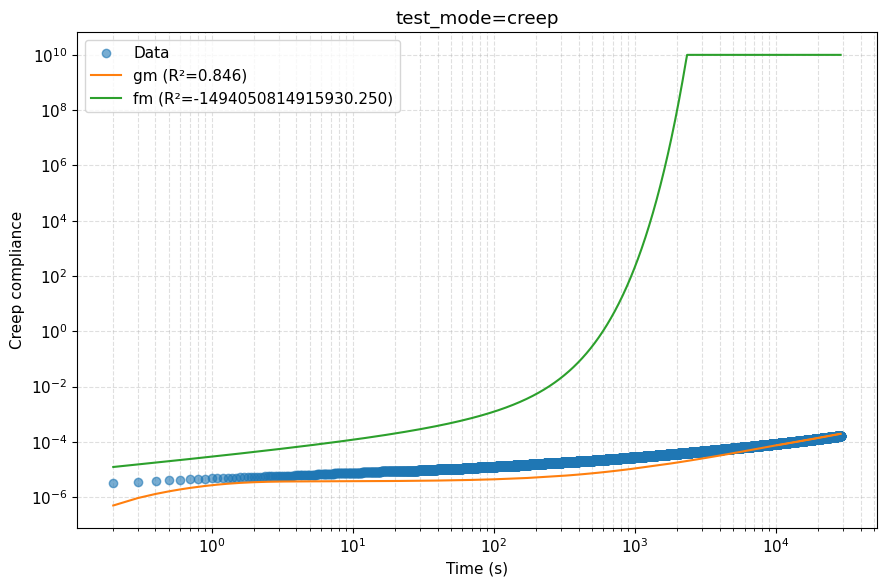

  0%|          | 0/700 [00:00<?, ?it/s]

warmup:   0%|          | 1/700 [00:00<08:22,  1.39it/s, 1 steps of size 1.95e+00. acc. prob=0.00]

warmup:   2%|▏         | 13/700 [00:00<00:33, 20.22it/s, 18 steps of size 1.54e-06. acc. prob=0.52]

warmup:   3%|▎         | 19/700 [00:00<00:27, 25.16it/s, 19 steps of size 6.53e-08. acc. prob=0.57]

warmup:   3%|▎         | 24/700 [00:01<00:25, 26.17it/s, 10 steps of size 1.74e-07. acc. prob=0.64]

warmup:   4%|▍         | 29/700 [00:01<00:28, 23.46it/s, 28 steps of size 4.66e-07. acc. prob=0.69]

warmup:   5%|▌         | 35/700 [00:01<00:23, 28.22it/s, 31 steps of size 4.52e-07. acc. prob=0.72]

warmup:   6%|▌         | 39/700 [00:01<00:23, 27.81it/s, 20 steps of size 4.43e-07. acc. prob=0.73]

warmup:   6%|▌         | 43/700 [00:01<00:29, 22.24it/s, 127 steps of size 1.03e-07. acc. prob=0.73]

warmup:   7%|▋         | 46/700 [00:02<01:05, 10.04it/s, 185 steps of size 7.40e-08. acc. prob=0.73]

warmup:   7%|▋         | 48/700 [00:03<01:18,  8.33it/s, 106 steps of size 1.20e-07. acc. prob=0.74]

warmup:   7%|▋         | 50/700 [00:03<01:13,  8.86it/s, 57 steps of size 1.34e-07. acc. prob=0.75] 

warmup:   7%|▋         | 52/700 [00:03<01:15,  8.61it/s, 70 steps of size 1.24e-07. acc. prob=0.75]

warmup:   8%|▊         | 55/700 [00:03<00:58, 11.05it/s, 37 steps of size 1.64e-07. acc. prob=0.76]

warmup:   8%|▊         | 57/700 [00:03<00:52, 12.22it/s, 16 steps of size 1.64e-07. acc. prob=0.76]

warmup:   9%|▉         | 62/700 [00:04<00:36, 17.54it/s, 25 steps of size 1.27e-07. acc. prob=0.77]

warmup:   9%|▉         | 65/700 [00:04<00:39, 16.20it/s, 34 steps of size 1.77e-07. acc. prob=0.77]

warmup:  10%|▉         | 68/700 [00:04<00:59, 10.62it/s, 109 steps of size 6.57e-08. acc. prob=0.77]

warmup:  10%|█         | 72/700 [00:04<00:47, 13.35it/s, 44 steps of size 9.72e-08. acc. prob=0.78] 

warmup:  11%|█         | 74/700 [00:05<00:51, 12.07it/s, 126 steps of size 1.26e-07. acc. prob=0.78]

warmup:  11%|█         | 76/700 [00:05<00:57, 10.89it/s, 85 steps of size 1.82e-07. acc. prob=0.78] 

warmup:  11%|█         | 78/700 [00:05<01:01, 10.16it/s, 74 steps of size 1.28e-07. acc. prob=0.78]

warmup:  11%|█▏        | 80/700 [00:06<01:26,  7.17it/s, 240 steps of size 8.50e-08. acc. prob=0.78]

warmup:  12%|█▏        | 81/700 [00:06<01:39,  6.21it/s, 178 steps of size 1.10e-07. acc. prob=0.79]

warmup:  12%|█▏        | 82/700 [00:06<01:47,  5.77it/s, 147 steps of size 1.32e-07. acc. prob=0.79]

warmup:  12%|█▏        | 83/700 [00:06<01:39,  6.20it/s, 73 steps of size 1.69e-07. acc. prob=0.79] 

warmup:  12%|█▏        | 86/700 [00:06<01:04,  9.56it/s, 32 steps of size 1.25e-07. acc. prob=0.79]

warmup:  13%|█▎        | 88/700 [00:07<01:32,  6.64it/s, 255 steps of size 5.73e-08. acc. prob=0.79]

warmup:  13%|█▎        | 90/700 [00:07<01:49,  5.58it/s, 255 steps of size 6.93e-08. acc. prob=0.79]

warmup:  13%|█▎        | 91/700 [00:08<01:40,  6.05it/s, 65 steps of size 5.51e-08. acc. prob=0.79] 

warmup:  13%|█▎        | 92/700 [00:08<01:36,  6.29it/s, 86 steps of size 6.81e-08. acc. prob=0.79]

warmup:  13%|█▎        | 93/700 [00:08<01:45,  5.75it/s, 143 steps of size 7.81e-08. acc. prob=0.79]

warmup:  14%|█▎        | 95/700 [00:08<01:18,  7.75it/s, 60 steps of size 1.12e-07. acc. prob=0.80] 

warmup:  14%|█▍        | 97/700 [00:08<01:15,  7.96it/s, 113 steps of size 1.09e-07. acc. prob=0.80]

warmup:  14%|█▍        | 100/700 [00:08<00:51, 11.62it/s, 11 steps of size 1.20e-07. acc. prob=0.80]

warmup:  15%|█▍        | 102/700 [00:09<01:46,  5.63it/s, 255 steps of size 1.91e-06. acc. prob=0.80]

warmup:  15%|█▍        | 104/700 [00:09<01:37,  6.09it/s, 111 steps of size 2.98e-06. acc. prob=0.81]

warmup:  15%|█▌        | 106/700 [00:10<01:46,  5.57it/s, 58 steps of size 4.10e-06. acc. prob=0.81] 

warmup:  15%|█▌        | 107/700 [00:10<01:54,  5.18it/s, 162 steps of size 5.60e-06. acc. prob=0.81]

warmup:  16%|█▌        | 109/700 [00:10<01:33,  6.32it/s, 86 steps of size 9.11e-06. acc. prob=0.81] 

warmup:  16%|█▌        | 110/700 [00:10<01:27,  6.72it/s, 70 steps of size 1.20e-05. acc. prob=0.82]

warmup:  16%|█▋        | 115/700 [00:11<00:44, 13.14it/s, 22 steps of size 4.92e-06. acc. prob=0.82]

warmup:  17%|█▋        | 118/700 [00:11<00:45, 12.72it/s, 134 steps of size 5.88e-06. acc. prob=0.82]

warmup:  17%|█▋        | 120/700 [00:11<00:46, 12.45it/s, 74 steps of size 6.19e-06. acc. prob=0.82] 

warmup:  17%|█▋        | 122/700 [00:11<00:50, 11.46it/s, 92 steps of size 7.68e-06. acc. prob=0.82]

warmup:  18%|█▊        | 124/700 [00:12<01:13,  7.83it/s, 148 steps of size 6.24e-06. acc. prob=0.82]

warmup:  18%|█▊        | 126/700 [00:12<01:03,  9.07it/s, 14 steps of size 6.16e-06. acc. prob=0.82] 

warmup:  18%|█▊        | 128/700 [00:12<00:53, 10.67it/s, 11 steps of size 5.85e-06. acc. prob=0.83]

warmup:  19%|█▊        | 130/700 [00:12<00:53, 10.58it/s, 33 steps of size 7.51e-06. acc. prob=0.83]

warmup:  19%|█▉        | 135/700 [00:12<00:32, 17.57it/s, 33 steps of size 2.18e-06. acc. prob=0.83]

warmup:  20%|█▉        | 138/700 [00:13<01:06,  8.50it/s, 244 steps of size 2.40e-06. acc. prob=0.83]

warmup:  20%|██        | 140/700 [00:14<01:33,  5.99it/s, 248 steps of size 3.72e-06. acc. prob=0.83]

warmup:  20%|██        | 142/700 [00:14<01:22,  6.75it/s, 62 steps of size 4.19e-06. acc. prob=0.83] 

warmup:  21%|██        | 144/700 [00:14<01:34,  5.91it/s, 183 steps of size 4.59e-06. acc. prob=0.83]

warmup:  21%|██        | 146/700 [00:14<01:18,  7.04it/s, 52 steps of size 5.80e-06. acc. prob=0.84] 

warmup:  21%|██        | 148/700 [00:15<01:30,  6.13it/s, 150 steps of size 4.63e-06. acc. prob=0.84]

warmup:  21%|██▏       | 150/700 [00:15<01:15,  7.25it/s, 39 steps of size 5.19e-06. acc. prob=0.84] 

warmup:  22%|██▏       | 156/700 [00:15<00:40, 13.52it/s, 34 steps of size 1.31e-06. acc. prob=0.83]

warmup:  23%|██▎       | 159/700 [00:16<01:00,  8.96it/s, 150 steps of size 1.16e-06. acc. prob=0.83]

warmup:  23%|██▎       | 161/700 [00:16<01:25,  6.33it/s, 255 steps of size 1.67e-06. acc. prob=0.83]

warmup:  23%|██▎       | 163/700 [00:17<01:54,  4.69it/s, 255 steps of size 2.42e-06. acc. prob=0.84]

warmup:  23%|██▎       | 164/700 [00:18<02:08,  4.18it/s, 255 steps of size 2.50e-06. acc. prob=0.84]

warmup:  24%|██▎       | 165/700 [00:18<02:04,  4.29it/s, 130 steps of size 3.39e-06. acc. prob=0.84]

warmup:  24%|██▎       | 166/700 [00:18<01:52,  4.74it/s, 76 steps of size 4.32e-06. acc. prob=0.84] 

warmup:  24%|██▍       | 168/700 [00:18<01:25,  6.21it/s, 67 steps of size 4.28e-06. acc. prob=0.84]

warmup:  24%|██▍       | 170/700 [00:18<01:20,  6.56it/s, 139 steps of size 5.58e-06. acc. prob=0.84]

warmup:  25%|██▍       | 174/700 [00:18<00:48, 10.82it/s, 21 steps of size 6.04e-06. acc. prob=0.84] 

warmup:  25%|██▌       | 176/700 [00:19<00:45, 11.44it/s, 69 steps of size 8.11e-06. acc. prob=0.84]

warmup:  25%|██▌       | 178/700 [00:19<00:40, 12.87it/s, 39 steps of size 1.20e-05. acc. prob=0.84]

warmup:  27%|██▋       | 187/700 [00:19<00:19, 26.49it/s, 48 steps of size 5.38e-08. acc. prob=0.84]

warmup:  27%|██▋       | 191/700 [00:20<00:46, 11.00it/s, 19 steps of size 1.48e-07. acc. prob=0.84]

warmup:  28%|██▊       | 194/700 [00:20<00:57,  8.82it/s, 63 steps of size 3.10e-07. acc. prob=0.84]

warmup:  28%|██▊       | 196/700 [00:21<01:11,  7.07it/s, 255 steps of size 5.09e-07. acc. prob=0.84]

warmup:  28%|██▊       | 198/700 [00:22<01:37,  5.14it/s, 255 steps of size 5.66e-07. acc. prob=0.84]

warmup:  29%|██▊       | 200/700 [00:22<02:00,  4.14it/s, 255 steps of size 7.12e-07. acc. prob=0.84]

sample:  29%|██▉       | 202/700 [00:23<01:59,  4.18it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  29%|██▉       | 203/700 [00:23<02:10,  3.80it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  29%|██▉       | 204/700 [00:24<02:22,  3.49it/s, 255 steps of size 7.12e-07. acc. prob=0.97]

sample:  29%|██▉       | 205/700 [00:24<02:33,  3.23it/s, 255 steps of size 7.12e-07. acc. prob=0.97]

sample:  29%|██▉       | 206/700 [00:24<02:36,  3.16it/s, 217 steps of size 7.12e-07. acc. prob=0.97]

sample:  30%|██▉       | 207/700 [00:25<02:45,  2.98it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  30%|██▉       | 208/700 [00:25<02:52,  2.84it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  30%|██▉       | 209/700 [00:26<02:58,  2.75it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  30%|███       | 210/700 [00:26<03:03,  2.68it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  30%|███       | 211/700 [00:26<02:45,  2.95it/s, 162 steps of size 7.12e-07. acc. prob=0.97]

sample:  30%|███       | 212/700 [00:27<02:53,  2.81it/s, 255 steps of size 7.12e-07. acc. prob=0.97]

sample:  30%|███       | 213/700 [00:27<02:59,  2.71it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  31%|███       | 214/700 [00:27<03:04,  2.64it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  31%|███       | 215/700 [00:28<03:06,  2.60it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  31%|███       | 216/700 [00:28<03:07,  2.58it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  31%|███       | 217/700 [00:29<02:53,  2.78it/s, 187 steps of size 7.12e-07. acc. prob=0.96]

sample:  31%|███       | 218/700 [00:29<02:58,  2.70it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  31%|███▏      | 219/700 [00:29<03:02,  2.64it/s, 255 steps of size 7.12e-07. acc. prob=0.95]

sample:  31%|███▏      | 220/700 [00:30<03:04,  2.61it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  32%|███▏      | 221/700 [00:30<03:05,  2.58it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  32%|███▏      | 222/700 [00:31<03:06,  2.56it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  32%|███▏      | 223/700 [00:31<02:34,  3.09it/s, 107 steps of size 7.12e-07. acc. prob=0.96]

sample:  32%|███▏      | 224/700 [00:31<02:16,  3.47it/s, 131 steps of size 7.12e-07. acc. prob=0.96]

sample:  32%|███▏      | 226/700 [00:31<01:35,  4.94it/s, 86 steps of size 7.12e-07. acc. prob=0.96] 

sample:  33%|███▎      | 228/700 [00:31<01:07,  7.02it/s, 44 steps of size 7.12e-07. acc. prob=0.96]

sample:  33%|███▎      | 229/700 [00:31<01:13,  6.43it/s, 129 steps of size 7.12e-07. acc. prob=0.96]

sample:  33%|███▎      | 230/700 [00:32<01:40,  4.68it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  33%|███▎      | 231/700 [00:32<02:02,  3.82it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  33%|███▎      | 232/700 [00:32<01:52,  4.16it/s, 116 steps of size 7.12e-07. acc. prob=0.96]

sample:  33%|███▎      | 233/700 [00:33<02:12,  3.52it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  34%|███▎      | 235/700 [00:33<01:46,  4.35it/s, 194 steps of size 7.12e-07. acc. prob=0.96]

sample:  34%|███▎      | 236/700 [00:33<01:45,  4.39it/s, 142 steps of size 7.12e-07. acc. prob=0.96]

sample:  34%|███▍      | 237/700 [00:34<02:05,  3.69it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  34%|███▍      | 238/700 [00:34<01:59,  3.87it/s, 138 steps of size 7.12e-07. acc. prob=0.96]

sample:  34%|███▍      | 240/700 [00:34<01:17,  5.93it/s, 37 steps of size 7.12e-07. acc. prob=0.96] 

sample:  34%|███▍      | 241/700 [00:34<01:28,  5.20it/s, 171 steps of size 7.12e-07. acc. prob=0.96]

sample:  35%|███▍      | 242/700 [00:35<01:39,  4.62it/s, 185 steps of size 7.12e-07. acc. prob=0.96]

sample:  35%|███▍      | 243/700 [00:35<02:01,  3.76it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  35%|███▍      | 244/700 [00:35<02:17,  3.31it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  35%|███▌      | 245/700 [00:36<02:00,  3.77it/s, 108 steps of size 7.12e-07. acc. prob=0.96]

sample:  35%|███▌      | 246/700 [00:36<01:53,  4.00it/s, 137 steps of size 7.12e-07. acc. prob=0.96]

sample:  35%|███▌      | 247/700 [00:36<01:48,  4.17it/s, 138 steps of size 7.12e-07. acc. prob=0.96]

sample:  35%|███▌      | 248/700 [00:36<02:04,  3.63it/s, 232 steps of size 7.12e-07. acc. prob=0.96]

sample:  36%|███▌      | 249/700 [00:37<02:20,  3.21it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  36%|███▌      | 250/700 [00:37<02:16,  3.29it/s, 185 steps of size 7.12e-07. acc. prob=0.96]

sample:  36%|███▌      | 251/700 [00:37<02:28,  3.02it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  36%|███▌      | 252/700 [00:38<02:41,  2.78it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  36%|███▌      | 253/700 [00:38<02:45,  2.70it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  36%|███▋      | 254/700 [00:39<02:48,  2.64it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  36%|███▋      | 255/700 [00:39<02:50,  2.61it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  37%|███▋      | 256/700 [00:39<02:52,  2.58it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  37%|███▋      | 257/700 [00:40<02:52,  2.56it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  37%|███▋      | 258/700 [00:40<02:53,  2.55it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  37%|███▋      | 259/700 [00:41<02:53,  2.54it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  37%|███▋      | 260/700 [00:41<02:53,  2.53it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  37%|███▋      | 261/700 [00:41<02:53,  2.53it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  37%|███▋      | 262/700 [00:42<02:53,  2.52it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  38%|███▊      | 263/700 [00:42<02:53,  2.52it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  38%|███▊      | 264/700 [00:43<02:53,  2.52it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  38%|███▊      | 265/700 [00:43<02:52,  2.52it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  38%|███▊      | 266/700 [00:43<02:52,  2.52it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  38%|███▊      | 267/700 [00:44<02:51,  2.52it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  38%|███▊      | 268/700 [00:44<02:51,  2.52it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  38%|███▊      | 269/700 [00:45<02:50,  2.52it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  39%|███▊      | 270/700 [00:45<02:50,  2.52it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  39%|███▊      | 271/700 [00:45<02:50,  2.51it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  39%|███▉      | 272/700 [00:46<02:50,  2.51it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  39%|███▉      | 273/700 [00:46<02:50,  2.51it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  39%|███▉      | 274/700 [00:47<02:49,  2.51it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  39%|███▉      | 275/700 [00:47<02:47,  2.53it/s, 248 steps of size 7.12e-07. acc. prob=0.96]

sample:  39%|███▉      | 276/700 [00:47<02:47,  2.53it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  40%|███▉      | 277/700 [00:48<02:48,  2.51it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  40%|███▉      | 278/700 [00:48<02:47,  2.51it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  40%|███▉      | 279/700 [00:49<02:47,  2.51it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  40%|████      | 280/700 [00:49<02:47,  2.51it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  40%|████      | 281/700 [00:49<02:48,  2.48it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  40%|████      | 282/700 [00:50<02:47,  2.49it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  40%|████      | 283/700 [00:50<02:46,  2.50it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  41%|████      | 284/700 [00:51<02:45,  2.51it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  41%|████      | 285/700 [00:51<02:45,  2.51it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  41%|████      | 286/700 [00:51<02:44,  2.51it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  41%|████      | 287/700 [00:52<02:44,  2.52it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  41%|████      | 288/700 [00:52<02:43,  2.51it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  41%|████▏     | 289/700 [00:53<02:43,  2.52it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  41%|████▏     | 290/700 [00:53<02:47,  2.45it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  42%|████▏     | 291/700 [00:53<02:46,  2.46it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  42%|████▏     | 292/700 [00:54<02:44,  2.48it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  42%|████▏     | 293/700 [00:54<02:33,  2.66it/s, 201 steps of size 7.12e-07. acc. prob=0.96]

sample:  42%|████▏     | 294/700 [00:55<02:35,  2.61it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  42%|████▏     | 295/700 [00:55<02:37,  2.58it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  42%|████▏     | 296/700 [00:55<02:38,  2.55it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  42%|████▏     | 297/700 [00:56<02:38,  2.54it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  43%|████▎     | 299/700 [00:56<02:07,  3.14it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  43%|████▎     | 300/700 [00:57<02:15,  2.96it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  43%|████▎     | 301/700 [00:57<02:21,  2.82it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  43%|████▎     | 302/700 [00:57<02:25,  2.73it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  43%|████▎     | 303/700 [00:58<02:28,  2.67it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  43%|████▎     | 304/700 [00:58<02:31,  2.61it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  44%|████▎     | 305/700 [00:59<02:32,  2.58it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  44%|████▎     | 306/700 [00:59<02:33,  2.57it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  44%|████▍     | 307/700 [00:59<02:34,  2.55it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  44%|████▍     | 308/700 [01:00<02:34,  2.54it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  44%|████▍     | 309/700 [01:00<02:34,  2.53it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  44%|████▍     | 310/700 [01:01<02:34,  2.52it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  44%|████▍     | 311/700 [01:01<02:06,  3.08it/s, 101 steps of size 7.12e-07. acc. prob=0.96]

sample:  45%|████▍     | 312/700 [01:01<02:08,  3.02it/s, 221 steps of size 7.12e-07. acc. prob=0.96]

sample:  45%|████▍     | 313/700 [01:01<02:07,  3.05it/s, 207 steps of size 7.12e-07. acc. prob=0.96]

sample:  45%|████▍     | 314/700 [01:02<02:14,  2.87it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  45%|████▌     | 315/700 [01:02<01:54,  3.35it/s, 116 steps of size 7.12e-07. acc. prob=0.96]

sample:  45%|████▌     | 316/700 [01:02<02:06,  3.04it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  45%|████▌     | 317/700 [01:03<02:13,  2.86it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  45%|████▌     | 318/700 [01:03<02:18,  2.75it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  46%|████▌     | 319/700 [01:04<02:22,  2.67it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  46%|████▌     | 320/700 [01:04<02:24,  2.62it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  46%|████▌     | 321/700 [01:04<02:10,  2.91it/s, 164 steps of size 7.12e-07. acc. prob=0.96]

sample:  46%|████▌     | 322/700 [01:05<02:15,  2.78it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  46%|████▌     | 323/700 [01:05<02:20,  2.69it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  46%|████▋     | 324/700 [01:05<02:22,  2.63it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  46%|████▋     | 325/700 [01:06<02:01,  3.10it/s, 122 steps of size 7.12e-07. acc. prob=0.96]

sample:  47%|████▋     | 326/700 [01:06<01:50,  3.40it/s, 144 steps of size 7.12e-07. acc. prob=0.96]

sample:  47%|████▋     | 327/700 [01:06<01:37,  3.84it/s, 116 steps of size 7.12e-07. acc. prob=0.96]

sample:  47%|████▋     | 329/700 [01:06<01:10,  5.23it/s, 86 steps of size 7.12e-07. acc. prob=0.96] 

sample:  47%|████▋     | 330/700 [01:07<01:29,  4.12it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  47%|████▋     | 331/700 [01:07<01:36,  3.84it/s, 199 steps of size 7.12e-07. acc. prob=0.96]

sample:  47%|████▋     | 332/700 [01:07<01:49,  3.35it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  48%|████▊     | 333/700 [01:08<01:43,  3.54it/s, 157 steps of size 7.12e-07. acc. prob=0.96]

sample:  48%|████▊     | 334/700 [01:08<01:37,  3.75it/s, 121 steps of size 7.12e-07. acc. prob=0.96]

sample:  48%|████▊     | 335/700 [01:08<01:29,  4.06it/s, 120 steps of size 7.12e-07. acc. prob=0.96]

sample:  48%|████▊     | 336/700 [01:08<01:45,  3.44it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  48%|████▊     | 337/700 [01:09<01:57,  3.10it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  48%|████▊     | 338/700 [01:09<02:05,  2.89it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  48%|████▊     | 339/700 [01:10<02:10,  2.77it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  49%|████▊     | 340/700 [01:10<02:13,  2.69it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  49%|████▊     | 341/700 [01:10<02:16,  2.63it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  49%|████▉     | 342/700 [01:11<02:17,  2.60it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  49%|████▉     | 343/700 [01:11<02:18,  2.58it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  49%|████▉     | 344/700 [01:12<02:19,  2.56it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  49%|████▉     | 345/700 [01:12<02:19,  2.54it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  49%|████▉     | 346/700 [01:12<02:19,  2.54it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  50%|████▉     | 347/700 [01:13<02:19,  2.52it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  50%|████▉     | 348/700 [01:13<02:19,  2.52it/s, 255 steps of size 7.12e-07. acc. prob=0.95]

sample:  50%|████▉     | 349/700 [01:14<02:19,  2.51it/s, 255 steps of size 7.12e-07. acc. prob=0.95]

sample:  50%|█████     | 350/700 [01:14<02:19,  2.51it/s, 255 steps of size 7.12e-07. acc. prob=0.95]

sample:  50%|█████     | 351/700 [01:14<02:19,  2.51it/s, 255 steps of size 7.12e-07. acc. prob=0.95]

sample:  50%|█████     | 352/700 [01:15<02:18,  2.51it/s, 255 steps of size 7.12e-07. acc. prob=0.95]

sample:  50%|█████     | 353/700 [01:15<02:18,  2.51it/s, 255 steps of size 7.12e-07. acc. prob=0.95]

sample:  51%|█████     | 354/700 [01:16<02:17,  2.51it/s, 255 steps of size 7.12e-07. acc. prob=0.95]

sample:  51%|█████     | 355/700 [01:16<02:21,  2.44it/s, 255 steps of size 7.12e-07. acc. prob=0.95]

sample:  51%|█████     | 356/700 [01:16<02:20,  2.45it/s, 255 steps of size 7.12e-07. acc. prob=0.95]

sample:  51%|█████     | 357/700 [01:17<02:21,  2.42it/s, 255 steps of size 7.12e-07. acc. prob=0.95]

sample:  51%|█████     | 358/700 [01:17<02:19,  2.45it/s, 255 steps of size 7.12e-07. acc. prob=0.95]

sample:  51%|█████▏    | 359/700 [01:18<02:18,  2.47it/s, 255 steps of size 7.12e-07. acc. prob=0.95]

sample:  51%|█████▏    | 360/700 [01:18<02:16,  2.48it/s, 255 steps of size 7.12e-07. acc. prob=0.95]

sample:  52%|█████▏    | 361/700 [01:18<02:16,  2.49it/s, 255 steps of size 7.12e-07. acc. prob=0.95]

sample:  52%|█████▏    | 362/700 [01:19<02:15,  2.50it/s, 255 steps of size 7.12e-07. acc. prob=0.95]

sample:  52%|█████▏    | 363/700 [01:19<02:14,  2.51it/s, 255 steps of size 7.12e-07. acc. prob=0.95]

sample:  52%|█████▏    | 364/700 [01:20<02:13,  2.51it/s, 255 steps of size 7.12e-07. acc. prob=0.95]

sample:  52%|█████▏    | 365/700 [01:20<02:13,  2.51it/s, 255 steps of size 7.12e-07. acc. prob=0.95]

sample:  52%|█████▏    | 366/700 [01:20<02:13,  2.51it/s, 255 steps of size 7.12e-07. acc. prob=0.95]

sample:  52%|█████▏    | 367/700 [01:21<02:12,  2.51it/s, 255 steps of size 7.12e-07. acc. prob=0.95]

sample:  53%|█████▎    | 368/700 [01:21<02:12,  2.51it/s, 255 steps of size 7.12e-07. acc. prob=0.95]

sample:  53%|█████▎    | 369/700 [01:22<02:11,  2.52it/s, 255 steps of size 7.12e-07. acc. prob=0.95]

sample:  53%|█████▎    | 370/700 [01:22<02:11,  2.52it/s, 255 steps of size 7.12e-07. acc. prob=0.95]

sample:  53%|█████▎    | 371/700 [01:22<02:10,  2.51it/s, 255 steps of size 7.12e-07. acc. prob=0.95]

sample:  53%|█████▎    | 372/700 [01:23<02:10,  2.51it/s, 255 steps of size 7.12e-07. acc. prob=0.95]

sample:  53%|█████▎    | 373/700 [01:23<02:10,  2.50it/s, 255 steps of size 7.12e-07. acc. prob=0.95]

sample:  53%|█████▎    | 374/700 [01:24<02:10,  2.51it/s, 255 steps of size 7.12e-07. acc. prob=0.95]

sample:  54%|█████▎    | 375/700 [01:24<02:09,  2.51it/s, 255 steps of size 7.12e-07. acc. prob=0.95]

sample:  54%|█████▎    | 376/700 [01:24<02:08,  2.51it/s, 255 steps of size 7.12e-07. acc. prob=0.95]

sample:  54%|█████▍    | 377/700 [01:25<02:08,  2.51it/s, 255 steps of size 7.12e-07. acc. prob=0.95]

sample:  54%|█████▍    | 378/700 [01:25<02:08,  2.51it/s, 255 steps of size 7.12e-07. acc. prob=0.95]

sample:  54%|█████▍    | 379/700 [01:26<02:07,  2.51it/s, 255 steps of size 7.12e-07. acc. prob=0.95]

sample:  54%|█████▍    | 380/700 [01:26<02:07,  2.51it/s, 255 steps of size 7.12e-07. acc. prob=0.95]

sample:  54%|█████▍    | 381/700 [01:26<02:06,  2.52it/s, 255 steps of size 7.12e-07. acc. prob=0.95]

sample:  55%|█████▍    | 382/700 [01:27<02:06,  2.51it/s, 255 steps of size 7.12e-07. acc. prob=0.95]

sample:  55%|█████▍    | 383/700 [01:27<02:06,  2.52it/s, 255 steps of size 7.12e-07. acc. prob=0.95]

sample:  55%|█████▍    | 384/700 [01:28<02:05,  2.52it/s, 255 steps of size 7.12e-07. acc. prob=0.95]

sample:  55%|█████▌    | 385/700 [01:28<02:05,  2.52it/s, 255 steps of size 7.12e-07. acc. prob=0.95]

sample:  55%|█████▌    | 386/700 [01:28<02:05,  2.51it/s, 255 steps of size 7.12e-07. acc. prob=0.95]

sample:  55%|█████▌    | 387/700 [01:29<02:06,  2.48it/s, 255 steps of size 7.12e-07. acc. prob=0.95]

sample:  55%|█████▌    | 388/700 [01:29<02:05,  2.49it/s, 255 steps of size 7.12e-07. acc. prob=0.95]

sample:  56%|█████▌    | 389/700 [01:30<02:04,  2.50it/s, 255 steps of size 7.12e-07. acc. prob=0.95]

sample:  56%|█████▌    | 390/700 [01:30<02:03,  2.51it/s, 255 steps of size 7.12e-07. acc. prob=0.95]

sample:  56%|█████▌    | 391/700 [01:30<02:03,  2.51it/s, 255 steps of size 7.12e-07. acc. prob=0.95]

sample:  56%|█████▌    | 392/700 [01:31<02:02,  2.51it/s, 255 steps of size 7.12e-07. acc. prob=0.95]

sample:  56%|█████▌    | 393/700 [01:31<02:02,  2.51it/s, 255 steps of size 7.12e-07. acc. prob=0.95]

sample:  56%|█████▋    | 394/700 [01:32<02:02,  2.51it/s, 255 steps of size 7.12e-07. acc. prob=0.95]

sample:  56%|█████▋    | 395/700 [01:32<02:01,  2.51it/s, 255 steps of size 7.12e-07. acc. prob=0.95]

sample:  57%|█████▋    | 396/700 [01:32<01:55,  2.64it/s, 212 steps of size 7.12e-07. acc. prob=0.95]

sample:  57%|█████▋    | 397/700 [01:33<01:56,  2.60it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  57%|█████▋    | 398/700 [01:33<01:57,  2.57it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  57%|█████▋    | 400/700 [01:33<01:20,  3.72it/s, 105 steps of size 7.12e-07. acc. prob=0.96]

sample:  57%|█████▋    | 401/700 [01:34<01:29,  3.33it/s, 255 steps of size 7.12e-07. acc. prob=0.95]

sample:  57%|█████▋    | 402/700 [01:34<01:37,  3.07it/s, 255 steps of size 7.12e-07. acc. prob=0.95]

sample:  58%|█████▊    | 403/700 [01:35<01:42,  2.89it/s, 255 steps of size 7.12e-07. acc. prob=0.95]

sample:  58%|█████▊    | 404/700 [01:35<01:46,  2.78it/s, 255 steps of size 7.12e-07. acc. prob=0.95]

sample:  58%|█████▊    | 405/700 [01:35<01:49,  2.70it/s, 255 steps of size 7.12e-07. acc. prob=0.95]

sample:  58%|█████▊    | 406/700 [01:36<01:51,  2.64it/s, 255 steps of size 7.12e-07. acc. prob=0.95]

sample:  58%|█████▊    | 407/700 [01:36<01:52,  2.61it/s, 255 steps of size 7.12e-07. acc. prob=0.95]

sample:  58%|█████▊    | 408/700 [01:37<01:53,  2.58it/s, 255 steps of size 7.12e-07. acc. prob=0.95]

sample:  58%|█████▊    | 409/700 [01:37<01:54,  2.55it/s, 255 steps of size 7.12e-07. acc. prob=0.95]

sample:  59%|█████▊    | 410/700 [01:37<01:54,  2.54it/s, 255 steps of size 7.12e-07. acc. prob=0.95]

sample:  59%|█████▊    | 411/700 [01:38<01:57,  2.46it/s, 255 steps of size 7.12e-07. acc. prob=0.95]

sample:  59%|█████▉    | 412/700 [01:38<01:56,  2.48it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  59%|█████▉    | 413/700 [01:38<01:45,  2.72it/s, 181 steps of size 7.12e-07. acc. prob=0.96]

sample:  59%|█████▉    | 414/700 [01:39<01:47,  2.66it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  59%|█████▉    | 415/700 [01:39<01:30,  3.16it/s, 114 steps of size 7.12e-07. acc. prob=0.96]

sample:  59%|█████▉    | 416/700 [01:39<01:36,  2.94it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  60%|█████▉    | 418/700 [01:40<01:22,  3.40it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  60%|█████▉    | 419/700 [01:40<01:29,  3.13it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  60%|██████    | 420/700 [01:41<01:35,  2.95it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  60%|██████    | 421/700 [01:41<01:39,  2.81it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  60%|██████    | 422/700 [01:41<01:42,  2.72it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  60%|██████    | 423/700 [01:42<01:44,  2.66it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  61%|██████    | 424/700 [01:42<01:45,  2.62it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  61%|██████    | 425/700 [01:43<01:46,  2.59it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  61%|██████    | 426/700 [01:43<01:46,  2.57it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  61%|██████    | 427/700 [01:43<01:47,  2.55it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  61%|██████    | 428/700 [01:44<01:47,  2.54it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  61%|██████▏   | 429/700 [01:44<01:46,  2.54it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  61%|██████▏   | 430/700 [01:45<01:46,  2.54it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  62%|██████▏   | 431/700 [01:45<01:46,  2.53it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  62%|██████▏   | 432/700 [01:45<01:46,  2.53it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  62%|██████▏   | 433/700 [01:46<01:45,  2.53it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  62%|██████▏   | 434/700 [01:46<01:45,  2.53it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  62%|██████▏   | 435/700 [01:47<01:45,  2.52it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  62%|██████▏   | 436/700 [01:47<01:43,  2.54it/s, 250 steps of size 7.12e-07. acc. prob=0.96]

sample:  62%|██████▏   | 437/700 [01:47<01:35,  2.76it/s, 186 steps of size 7.12e-07. acc. prob=0.96]

sample:  63%|██████▎   | 438/700 [01:48<01:22,  3.19it/s, 126 steps of size 7.12e-07. acc. prob=0.96]

sample:  63%|██████▎   | 439/700 [01:48<01:28,  2.96it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  63%|██████▎   | 440/700 [01:48<01:32,  2.80it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  63%|██████▎   | 441/700 [01:49<01:35,  2.70it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  63%|██████▎   | 442/700 [01:49<01:37,  2.64it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  63%|██████▎   | 443/700 [01:50<01:38,  2.60it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  63%|██████▎   | 444/700 [01:50<01:39,  2.58it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  64%|██████▎   | 445/700 [01:50<01:39,  2.56it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  64%|██████▎   | 446/700 [01:51<01:39,  2.55it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  64%|██████▍   | 447/700 [01:51<01:39,  2.54it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  64%|██████▍   | 448/700 [01:52<01:39,  2.53it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  64%|██████▍   | 449/700 [01:52<01:39,  2.53it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  64%|██████▍   | 450/700 [01:52<01:38,  2.53it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  64%|██████▍   | 451/700 [01:53<01:38,  2.53it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  65%|██████▍   | 452/700 [01:53<01:38,  2.52it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  65%|██████▍   | 453/700 [01:53<01:38,  2.51it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  65%|██████▍   | 454/700 [01:54<01:37,  2.52it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  65%|██████▌   | 455/700 [01:54<01:37,  2.51it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  65%|██████▌   | 456/700 [01:55<01:37,  2.51it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  65%|██████▌   | 457/700 [01:55<01:36,  2.51it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  65%|██████▌   | 458/700 [01:55<01:36,  2.51it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  66%|██████▌   | 459/700 [01:56<01:35,  2.51it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  66%|██████▌   | 460/700 [01:56<01:35,  2.51it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  66%|██████▌   | 461/700 [01:57<01:35,  2.52it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  66%|██████▌   | 462/700 [01:57<01:34,  2.51it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  66%|██████▌   | 463/700 [01:57<01:34,  2.51it/s, 255 steps of size 7.12e-07. acc. prob=0.95]

sample:  66%|██████▋   | 464/700 [01:58<01:33,  2.52it/s, 255 steps of size 7.12e-07. acc. prob=0.95]

sample:  66%|██████▋   | 465/700 [01:58<01:34,  2.50it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  67%|██████▋   | 466/700 [01:59<01:33,  2.51it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  67%|██████▋   | 467/700 [01:59<01:32,  2.51it/s, 255 steps of size 7.12e-07. acc. prob=0.95]

sample:  67%|██████▋   | 468/700 [01:59<01:32,  2.51it/s, 255 steps of size 7.12e-07. acc. prob=0.95]

sample:  67%|██████▋   | 469/700 [02:00<01:31,  2.52it/s, 255 steps of size 7.12e-07. acc. prob=0.95]

sample:  67%|██████▋   | 470/700 [02:00<01:31,  2.52it/s, 255 steps of size 7.12e-07. acc. prob=0.95]

sample:  67%|██████▋   | 471/700 [02:01<01:33,  2.44it/s, 255 steps of size 7.12e-07. acc. prob=0.95]

sample:  67%|██████▋   | 472/700 [02:01<01:32,  2.46it/s, 255 steps of size 7.12e-07. acc. prob=0.95]

sample:  68%|██████▊   | 473/700 [02:01<01:31,  2.48it/s, 255 steps of size 7.12e-07. acc. prob=0.95]

sample:  68%|██████▊   | 474/700 [02:02<01:30,  2.49it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  68%|██████▊   | 475/700 [02:02<01:30,  2.50it/s, 255 steps of size 7.12e-07. acc. prob=0.95]

sample:  68%|██████▊   | 476/700 [02:03<01:29,  2.50it/s, 255 steps of size 7.12e-07. acc. prob=0.95]

sample:  68%|██████▊   | 477/700 [02:03<01:21,  2.72it/s, 186 steps of size 7.12e-07. acc. prob=0.95]

sample:  68%|██████▊   | 478/700 [02:03<01:23,  2.65it/s, 255 steps of size 7.12e-07. acc. prob=0.95]

sample:  68%|██████▊   | 479/700 [02:04<01:24,  2.61it/s, 255 steps of size 7.12e-07. acc. prob=0.95]

sample:  69%|██████▊   | 480/700 [02:04<01:25,  2.57it/s, 255 steps of size 7.12e-07. acc. prob=0.95]

sample:  69%|██████▊   | 481/700 [02:05<01:25,  2.56it/s, 255 steps of size 7.12e-07. acc. prob=0.95]

sample:  69%|██████▉   | 482/700 [02:05<01:25,  2.55it/s, 255 steps of size 7.12e-07. acc. prob=0.95]

sample:  69%|██████▉   | 483/700 [02:05<01:25,  2.54it/s, 255 steps of size 7.12e-07. acc. prob=0.95]

sample:  69%|██████▉   | 484/700 [02:06<01:25,  2.53it/s, 255 steps of size 7.12e-07. acc. prob=0.95]

sample:  69%|██████▉   | 485/700 [02:06<01:24,  2.54it/s, 255 steps of size 7.12e-07. acc. prob=0.95]

sample:  69%|██████▉   | 486/700 [02:06<01:16,  2.81it/s, 171 steps of size 7.12e-07. acc. prob=0.95]

sample:  70%|██████▉   | 487/700 [02:07<01:09,  3.07it/s, 162 steps of size 7.12e-07. acc. prob=0.95]

sample:  70%|██████▉   | 489/700 [02:07<00:43,  4.89it/s, 34 steps of size 7.12e-07. acc. prob=0.95] 

sample:  70%|███████   | 491/700 [02:07<00:36,  5.70it/s, 120 steps of size 7.12e-07. acc. prob=0.95]

sample:  70%|███████   | 492/700 [02:07<00:43,  4.76it/s, 214 steps of size 7.12e-07. acc. prob=0.95]

sample:  70%|███████   | 493/700 [02:08<00:53,  3.90it/s, 255 steps of size 7.12e-07. acc. prob=0.95]

sample:  71%|███████   | 494/700 [02:08<01:00,  3.39it/s, 255 steps of size 7.12e-07. acc. prob=0.95]

sample:  71%|███████   | 495/700 [02:09<01:06,  3.10it/s, 255 steps of size 7.12e-07. acc. prob=0.95]

sample:  71%|███████   | 496/700 [02:09<01:10,  2.90it/s, 255 steps of size 7.12e-07. acc. prob=0.95]

sample:  71%|███████   | 497/700 [02:09<01:12,  2.78it/s, 255 steps of size 7.12e-07. acc. prob=0.95]

sample:  71%|███████   | 498/700 [02:10<01:14,  2.70it/s, 255 steps of size 7.12e-07. acc. prob=0.95]

sample:  71%|███████▏  | 499/700 [02:10<01:15,  2.65it/s, 255 steps of size 7.12e-07. acc. prob=0.95]

sample:  71%|███████▏  | 500/700 [02:11<01:16,  2.61it/s, 255 steps of size 7.12e-07. acc. prob=0.95]

sample:  72%|███████▏  | 501/700 [02:11<01:17,  2.58it/s, 255 steps of size 7.12e-07. acc. prob=0.95]

sample:  72%|███████▏  | 502/700 [02:11<01:17,  2.56it/s, 255 steps of size 7.12e-07. acc. prob=0.95]

sample:  72%|███████▏  | 503/700 [02:12<01:17,  2.55it/s, 255 steps of size 7.12e-07. acc. prob=0.95]

sample:  72%|███████▏  | 504/700 [02:12<01:17,  2.54it/s, 255 steps of size 7.12e-07. acc. prob=0.95]

sample:  72%|███████▏  | 505/700 [02:13<01:16,  2.53it/s, 255 steps of size 7.12e-07. acc. prob=0.95]

sample:  72%|███████▏  | 506/700 [02:13<01:16,  2.52it/s, 255 steps of size 7.12e-07. acc. prob=0.95]

sample:  72%|███████▏  | 507/700 [02:13<01:16,  2.52it/s, 255 steps of size 7.12e-07. acc. prob=0.95]

sample:  73%|███████▎  | 508/700 [02:14<01:16,  2.52it/s, 255 steps of size 7.12e-07. acc. prob=0.95]

sample:  73%|███████▎  | 509/700 [02:14<01:15,  2.51it/s, 255 steps of size 7.12e-07. acc. prob=0.95]

sample:  73%|███████▎  | 510/700 [02:14<01:10,  2.70it/s, 198 steps of size 7.12e-07. acc. prob=0.95]

sample:  73%|███████▎  | 511/700 [02:15<01:07,  2.81it/s, 205 steps of size 7.12e-07. acc. prob=0.96]

sample:  73%|███████▎  | 512/700 [02:15<01:09,  2.72it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  73%|███████▎  | 513/700 [02:16<01:10,  2.66it/s, 255 steps of size 7.12e-07. acc. prob=0.95]

sample:  73%|███████▎  | 514/700 [02:16<01:11,  2.62it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  74%|███████▎  | 515/700 [02:16<00:55,  3.33it/s, 70 steps of size 7.12e-07. acc. prob=0.96] 

sample:  74%|███████▎  | 516/700 [02:17<01:00,  3.02it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  74%|███████▍  | 517/700 [02:17<00:51,  3.55it/s, 107 steps of size 7.12e-07. acc. prob=0.96]

sample:  74%|███████▍  | 518/700 [02:17<00:41,  4.36it/s, 68 steps of size 7.12e-07. acc. prob=0.96] 

sample:  74%|███████▍  | 519/700 [02:17<00:41,  4.35it/s, 148 steps of size 7.12e-07. acc. prob=0.96]

sample:  74%|███████▍  | 520/700 [02:17<00:44,  4.01it/s, 189 steps of size 7.12e-07. acc. prob=0.96]

sample:  74%|███████▍  | 521/700 [02:18<00:52,  3.41it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  75%|███████▍  | 522/700 [02:18<00:45,  3.91it/s, 108 steps of size 7.12e-07. acc. prob=0.96]

sample:  75%|███████▍  | 523/700 [02:18<00:52,  3.35it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  75%|███████▍  | 524/700 [02:18<00:47,  3.68it/s, 135 steps of size 7.12e-07. acc. prob=0.96]

sample:  75%|███████▌  | 526/700 [02:19<00:43,  4.03it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  75%|███████▌  | 527/700 [02:19<00:49,  3.50it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  75%|███████▌  | 528/700 [02:20<00:50,  3.40it/s, 206 steps of size 7.12e-07. acc. prob=0.96]

sample:  76%|███████▌  | 529/700 [02:20<00:55,  3.10it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  76%|███████▌  | 530/700 [02:20<00:58,  2.91it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  76%|███████▌  | 531/700 [02:21<00:50,  3.35it/s, 120 steps of size 7.12e-07. acc. prob=0.96]

sample:  76%|███████▌  | 532/700 [02:21<00:54,  3.06it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  76%|███████▌  | 533/700 [02:21<00:58,  2.88it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  76%|███████▋  | 534/700 [02:22<01:00,  2.76it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  76%|███████▋  | 535/700 [02:22<00:58,  2.81it/s, 221 steps of size 7.12e-07. acc. prob=0.96]

sample:  77%|███████▋  | 536/700 [02:23<01:00,  2.71it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  77%|███████▋  | 537/700 [02:23<01:02,  2.59it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  77%|███████▋  | 538/700 [02:23<00:56,  2.86it/s, 143 steps of size 7.12e-07. acc. prob=0.96]

sample:  77%|███████▋  | 539/700 [02:24<00:58,  2.75it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  77%|███████▋  | 540/700 [02:24<00:59,  2.68it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  77%|███████▋  | 541/700 [02:24<01:00,  2.63it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  77%|███████▋  | 542/700 [02:25<01:01,  2.59it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  78%|███████▊  | 543/700 [02:25<01:01,  2.56it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  78%|███████▊  | 544/700 [02:26<01:01,  2.55it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  78%|███████▊  | 545/700 [02:26<01:01,  2.54it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  78%|███████▊  | 546/700 [02:26<01:00,  2.53it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  78%|███████▊  | 547/700 [02:27<01:00,  2.53it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  78%|███████▊  | 548/700 [02:27<01:00,  2.53it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  78%|███████▊  | 549/700 [02:28<00:59,  2.52it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  79%|███████▊  | 550/700 [02:28<00:59,  2.52it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  79%|███████▊  | 551/700 [02:28<00:59,  2.52it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  79%|███████▉  | 552/700 [02:29<00:58,  2.52it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  79%|███████▉  | 553/700 [02:29<00:58,  2.52it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  79%|███████▉  | 554/700 [02:30<00:58,  2.51it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  79%|███████▉  | 555/700 [02:30<00:57,  2.51it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  79%|███████▉  | 556/700 [02:30<00:57,  2.51it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  80%|███████▉  | 557/700 [02:31<00:49,  2.88it/s, 148 steps of size 7.12e-07. acc. prob=0.96]

sample:  80%|███████▉  | 559/700 [02:31<00:30,  4.58it/s, 29 steps of size 7.12e-07. acc. prob=0.96] 

sample:  80%|████████  | 560/700 [02:31<00:32,  4.35it/s, 170 steps of size 7.12e-07. acc. prob=0.96]

sample:  80%|████████  | 561/700 [02:31<00:28,  4.95it/s, 79 steps of size 7.12e-07. acc. prob=0.96] 

sample:  80%|████████  | 562/700 [02:31<00:33,  4.15it/s, 219 steps of size 7.12e-07. acc. prob=0.96]

sample:  80%|████████  | 563/700 [02:32<00:32,  4.28it/s, 139 steps of size 7.12e-07. acc. prob=0.96]

sample:  81%|████████  | 564/700 [02:32<00:38,  3.56it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  81%|████████  | 565/700 [02:33<00:42,  3.16it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  81%|████████  | 566/700 [02:33<00:45,  2.94it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  81%|████████  | 567/700 [02:33<00:45,  2.89it/s, 230 steps of size 7.12e-07. acc. prob=0.96]

sample:  81%|████████  | 568/700 [02:34<00:47,  2.77it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  81%|████████▏ | 569/700 [02:34<00:48,  2.69it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  81%|████████▏ | 570/700 [02:34<00:49,  2.64it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  82%|████████▏ | 571/700 [02:35<00:49,  2.61it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  82%|████████▏ | 572/700 [02:35<00:49,  2.58it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  82%|████████▏ | 573/700 [02:36<00:49,  2.56it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  82%|████████▏ | 575/700 [02:36<00:29,  4.28it/s, 42 steps of size 7.12e-07. acc. prob=0.96] 

sample:  82%|████████▏ | 576/700 [02:36<00:26,  4.73it/s, 91 steps of size 7.12e-07. acc. prob=0.96]

sample:  82%|████████▏ | 577/700 [02:36<00:22,  5.46it/s, 65 steps of size 7.12e-07. acc. prob=0.96]

sample:  83%|████████▎ | 578/700 [02:36<00:22,  5.32it/s, 128 steps of size 7.12e-07. acc. prob=0.96]

sample:  83%|████████▎ | 579/700 [02:37<00:29,  4.06it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  83%|████████▎ | 580/700 [02:37<00:34,  3.46it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  83%|████████▎ | 581/700 [02:37<00:38,  3.12it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  83%|████████▎ | 582/700 [02:38<00:40,  2.92it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  83%|████████▎ | 583/700 [02:38<00:41,  2.79it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  83%|████████▎ | 584/700 [02:39<00:42,  2.70it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  84%|████████▎ | 585/700 [02:39<00:43,  2.65it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  84%|████████▎ | 586/700 [02:39<00:43,  2.61it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  84%|████████▍ | 587/700 [02:40<00:43,  2.58it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  84%|████████▍ | 588/700 [02:40<00:43,  2.56it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  84%|████████▍ | 589/700 [02:41<00:43,  2.54it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  84%|████████▍ | 590/700 [02:41<00:43,  2.53it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  84%|████████▍ | 591/700 [02:41<00:43,  2.53it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  85%|████████▍ | 592/700 [02:42<00:42,  2.53it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  85%|████████▍ | 593/700 [02:42<00:42,  2.52it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  85%|████████▍ | 594/700 [02:43<00:42,  2.51it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  85%|████████▌ | 595/700 [02:43<00:42,  2.50it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  85%|████████▌ | 596/700 [02:43<00:41,  2.50it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  85%|████████▌ | 597/700 [02:44<00:41,  2.50it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  85%|████████▌ | 598/700 [02:44<00:40,  2.51it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  86%|████████▌ | 599/700 [02:45<00:40,  2.51it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  86%|████████▌ | 600/700 [02:45<00:39,  2.51it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  86%|████████▌ | 601/700 [02:45<00:39,  2.52it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  86%|████████▌ | 602/700 [02:46<00:38,  2.52it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  86%|████████▌ | 603/700 [02:46<00:38,  2.52it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  86%|████████▋ | 604/700 [02:47<00:38,  2.52it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  86%|████████▋ | 605/700 [02:47<00:37,  2.52it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  87%|████████▋ | 606/700 [02:47<00:37,  2.49it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  87%|████████▋ | 607/700 [02:48<00:37,  2.50it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  87%|████████▋ | 608/700 [02:48<00:37,  2.44it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  87%|████████▋ | 609/700 [02:49<00:37,  2.45it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  87%|████████▋ | 610/700 [02:49<00:36,  2.47it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  87%|████████▋ | 611/700 [02:49<00:35,  2.47it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  87%|████████▋ | 612/700 [02:50<00:35,  2.48it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  88%|████████▊ | 613/700 [02:50<00:35,  2.48it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  88%|████████▊ | 614/700 [02:51<00:34,  2.49it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  88%|████████▊ | 615/700 [02:51<00:34,  2.50it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  88%|████████▊ | 616/700 [02:51<00:33,  2.50it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  88%|████████▊ | 617/700 [02:52<00:33,  2.51it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  88%|████████▊ | 618/700 [02:52<00:32,  2.51it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  88%|████████▊ | 619/700 [02:53<00:32,  2.51it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  89%|████████▊ | 620/700 [02:53<00:31,  2.51it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  89%|████████▊ | 621/700 [02:53<00:31,  2.51it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  89%|████████▉ | 622/700 [02:54<00:31,  2.51it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  89%|████████▉ | 623/700 [02:54<00:30,  2.51it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  89%|████████▉ | 624/700 [02:55<00:30,  2.51it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  89%|████████▉ | 625/700 [02:55<00:29,  2.51it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  89%|████████▉ | 626/700 [02:55<00:29,  2.51it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  90%|████████▉ | 627/700 [02:56<00:29,  2.51it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  90%|████████▉ | 628/700 [02:56<00:28,  2.51it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  90%|████████▉ | 629/700 [02:57<00:28,  2.51it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  90%|█████████ | 630/700 [02:57<00:27,  2.51it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  90%|█████████ | 631/700 [02:57<00:27,  2.51it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  90%|█████████ | 632/700 [02:58<00:27,  2.52it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  90%|█████████ | 633/700 [02:58<00:26,  2.50it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  91%|█████████ | 634/700 [02:59<00:26,  2.50it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  91%|█████████ | 635/700 [02:59<00:25,  2.51it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  91%|█████████ | 636/700 [02:59<00:25,  2.51it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  91%|█████████ | 637/700 [03:00<00:25,  2.51it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  91%|█████████ | 638/700 [03:00<00:24,  2.51it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  91%|█████████▏| 639/700 [03:01<00:24,  2.51it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  91%|█████████▏| 640/700 [03:01<00:23,  2.50it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  92%|█████████▏| 641/700 [03:01<00:23,  2.50it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  92%|█████████▏| 642/700 [03:02<00:23,  2.50it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  92%|█████████▏| 643/700 [03:02<00:22,  2.51it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  92%|█████████▏| 644/700 [03:03<00:22,  2.51it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  92%|█████████▏| 645/700 [03:03<00:21,  2.51it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  92%|█████████▏| 646/700 [03:03<00:21,  2.52it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  92%|█████████▏| 647/700 [03:04<00:21,  2.51it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  93%|█████████▎| 648/700 [03:04<00:20,  2.52it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  93%|█████████▎| 649/700 [03:05<00:20,  2.51it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  93%|█████████▎| 650/700 [03:05<00:19,  2.52it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  93%|█████████▎| 651/700 [03:05<00:19,  2.52it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  93%|█████████▎| 652/700 [03:06<00:19,  2.52it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  93%|█████████▎| 653/700 [03:06<00:18,  2.51it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  93%|█████████▎| 654/700 [03:07<00:18,  2.51it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  94%|█████████▎| 655/700 [03:07<00:17,  2.51it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  94%|█████████▎| 656/700 [03:07<00:17,  2.52it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  94%|█████████▍| 657/700 [03:08<00:17,  2.52it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  94%|█████████▍| 658/700 [03:08<00:16,  2.52it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  94%|█████████▍| 659/700 [03:08<00:16,  2.52it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  94%|█████████▍| 660/700 [03:09<00:13,  3.05it/s, 108 steps of size 7.12e-07. acc. prob=0.96]

sample:  94%|█████████▍| 661/700 [03:09<00:13,  2.85it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  95%|█████████▍| 662/700 [03:09<00:13,  2.74it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  95%|█████████▍| 663/700 [03:10<00:13,  2.67it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  95%|█████████▍| 664/700 [03:10<00:13,  2.60it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  95%|█████████▌| 665/700 [03:11<00:13,  2.57it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  95%|█████████▌| 666/700 [03:11<00:13,  2.55it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  95%|█████████▌| 667/700 [03:11<00:13,  2.54it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  95%|█████████▌| 668/700 [03:12<00:12,  2.53it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  96%|█████████▌| 669/700 [03:12<00:12,  2.52it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  96%|█████████▌| 670/700 [03:13<00:11,  2.52it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  96%|█████████▌| 671/700 [03:13<00:11,  2.52it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  96%|█████████▌| 672/700 [03:13<00:11,  2.45it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  96%|█████████▌| 673/700 [03:14<00:10,  2.47it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  96%|█████████▋| 674/700 [03:14<00:10,  2.48it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  96%|█████████▋| 675/700 [03:15<00:10,  2.49it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  97%|█████████▋| 676/700 [03:15<00:09,  2.58it/s, 227 steps of size 7.12e-07. acc. prob=0.96]

sample:  97%|█████████▋| 677/700 [03:15<00:09,  2.54it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  97%|█████████▋| 678/700 [03:16<00:08,  2.59it/s, 234 steps of size 7.12e-07. acc. prob=0.96]

sample:  97%|█████████▋| 679/700 [03:16<00:08,  2.57it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  97%|█████████▋| 680/700 [03:17<00:07,  2.55it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  97%|█████████▋| 681/700 [03:17<00:07,  2.54it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  97%|█████████▋| 682/700 [03:17<00:06,  2.61it/s, 231 steps of size 7.12e-07. acc. prob=0.96]

sample:  98%|█████████▊| 683/700 [03:18<00:05,  3.18it/s, 97 steps of size 7.12e-07. acc. prob=0.96] 

sample:  98%|█████████▊| 684/700 [03:18<00:05,  2.96it/s, 252 steps of size 7.12e-07. acc. prob=0.96]

sample:  98%|█████████▊| 686/700 [03:18<00:04,  3.39it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  98%|█████████▊| 687/700 [03:19<00:04,  3.21it/s, 230 steps of size 7.12e-07. acc. prob=0.96]

sample:  98%|█████████▊| 688/700 [03:19<00:03,  3.00it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  98%|█████████▊| 689/700 [03:20<00:03,  2.83it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  99%|█████████▊| 690/700 [03:20<00:03,  2.71it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  99%|█████████▊| 691/700 [03:20<00:03,  2.61it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  99%|█████████▉| 692/700 [03:21<00:03,  2.59it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  99%|█████████▉| 693/700 [03:21<00:02,  2.57it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  99%|█████████▉| 694/700 [03:22<00:02,  2.56it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  99%|█████████▉| 695/700 [03:22<00:01,  2.55it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample:  99%|█████████▉| 696/700 [03:22<00:01,  2.63it/s, 224 steps of size 7.12e-07. acc. prob=0.96]

sample: 100%|█████████▉| 697/700 [03:23<00:01,  2.60it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample: 100%|█████████▉| 698/700 [03:23<00:00,  3.29it/s, 73 steps of size 7.12e-07. acc. prob=0.96] 

sample: 100%|█████████▉| 699/700 [03:23<00:00,  3.02it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample: 100%|██████████| 700/700 [03:24<00:00,  2.85it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

sample: 100%|██████████| 700/700 [03:24<00:00,  3.43it/s, 255 steps of size 7.12e-07. acc. prob=0.96]

Dataset 0: Bayesian inference complete for gm


In [9]:
# Bayesian inference on best model per dataset
def _plot_data_and_fits(ds, fits):
    """Plot data with model fits overlay."""
    fig, ax = plt.subplots(figsize=(9, 6))
    X_plot, y_true = ds['X'], ds['y']
    if np.iscomplexobj(y_true):
        x_axis = X_plot / (2 * np.pi) if ds['test_mode'] == 'oscillation' else X_plot
        ax.loglog(x_axis, np.real(y_true), 'o', label="Data real", alpha=0.6)
        ax.loglog(x_axis, np.imag(y_true), 's', label="Data imag", alpha=0.6)
        for rec in fits:
            pred = _coerce_pred(rec['pred'])
            ax.loglog(x_axis, np.real(pred), '-', label=f"{rec['name']} Re (R²={rec['r2']:.3f})")
            ax.loglog(x_axis, np.imag(pred), '--', label=f"{rec['name']} Im")
    else:
        ax.loglog(X_plot, y_true, 'o', label='Data', alpha=0.6)
        for rec in fits:
            ax.loglog(X_plot, rec['pred'], '-', label=f"{rec['name']} (R²={rec['r2']:.3f})")
    ax.set_xlabel(ds.get('x_label', 'X'))
    ax.set_ylabel(ds.get('y_label', 'Response'))
    ax.set_title(ds.get('label', f"test_mode={ds['test_mode']}"))
    ax.grid(True, which='both', ls='--', alpha=0.4)
    ax.legend()
    plt.tight_layout()
    display(fig)
    plt.close(fig)

bayes_results = {}  # {dataset_idx: (bayes_result, param_names)}

for ds_idx, ds in enumerate(datasets):
    fits = all_fits.get(ds_idx, [])
    if not fits:
        continue

    best = fits[0]
    _plot_data_and_fits(ds, fits)

    try:
        bayes_result = best['model'].fit_bayesian(
            ds['X'], ds['y'], **NUTS_CONFIG, test_mode=ds['test_mode'],
        )
        param_names = list(best['model'].parameters.keys())
        bayes_results[ds_idx] = (bayes_result, param_names)
        print(f"Dataset {ds_idx}: Bayesian inference complete for {best['name']}")
    except Exception as exc:
        print(f"Dataset {ds_idx}: Bayesian step failed for {best['name']}: {exc}")



--- Diagnostics for dataset 0 ---


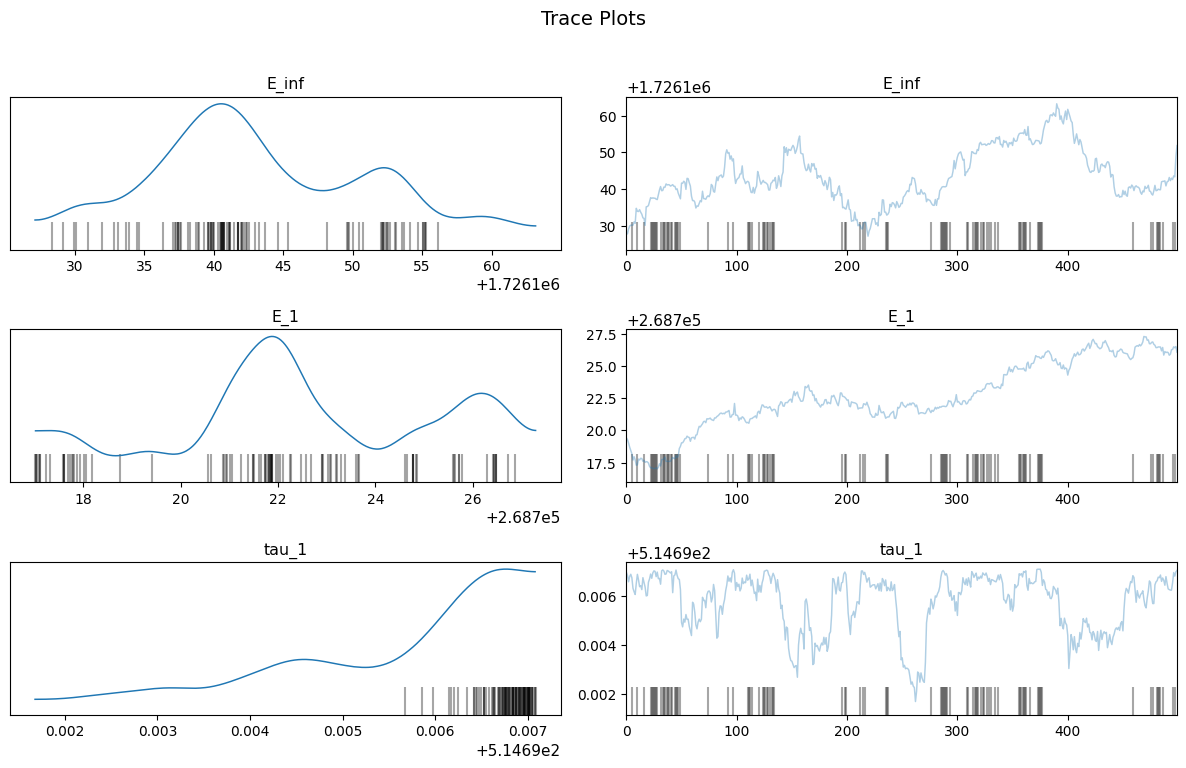

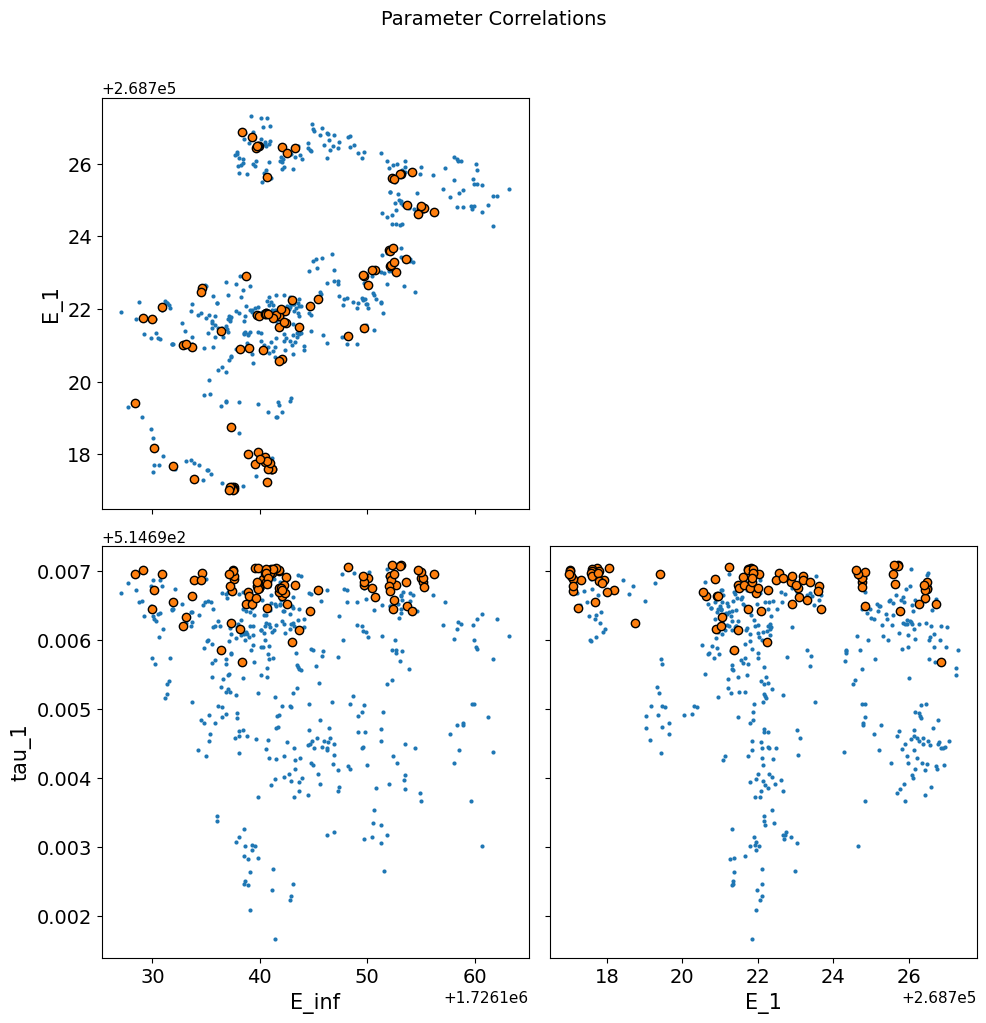

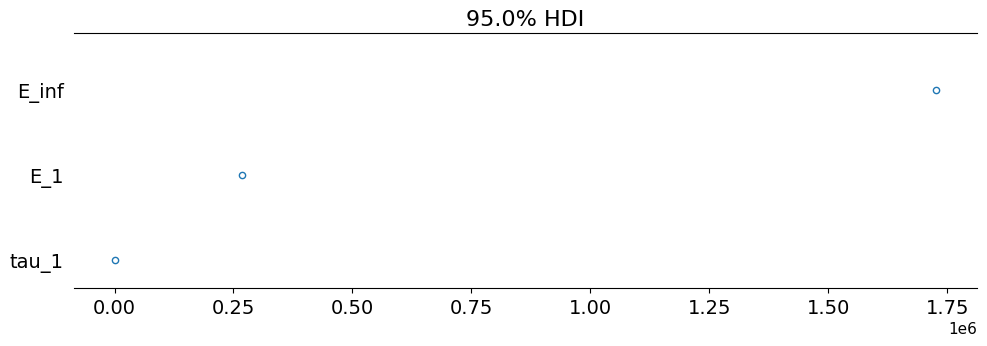

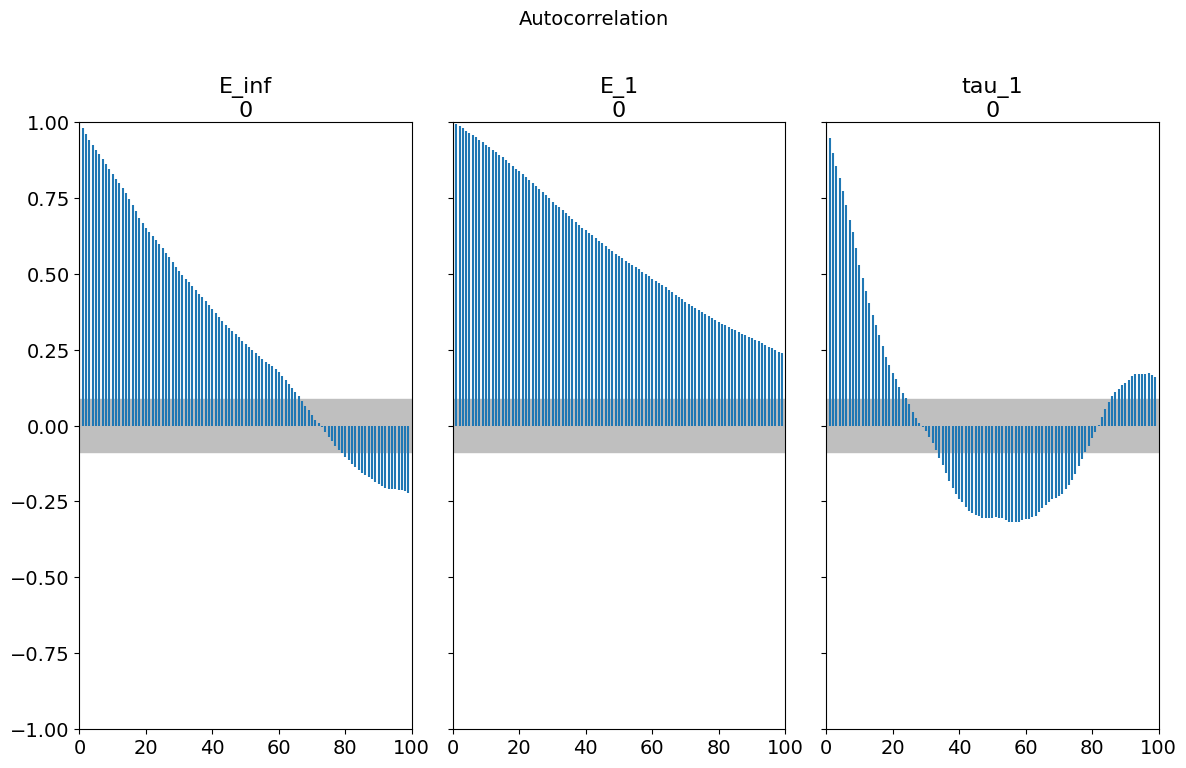

In [10]:
# ArviZ diagnostics for Bayesian results
for ds_idx, (bayes_result, param_names) in bayes_results.items():
    print(f"\n--- Diagnostics for dataset {ds_idx} ---")
    display_arviz_diagnostics(bayes_result, param_names, fast_mode=True)
